# **Modeling and Evaluation**

## Objectives

- Address Business Requirement 2: Develop a model to determine whether a given leaf is infected with powdery mildew.

- Implement machine learning techniques to train and evaluate a classification model.

## Inputs
- Dataset Directories:
- `inputs/mildew_dataset_dataset/cherry-leaves/train`
- `inputs/mildew_dataset_dataset/cherry-leaves/test`
- `inputs/mildew_dataset_dataset/cherry-leaves/validation`
- Image Shape Embeddings: Precomputed embeddings from the Data Visualization Notebook.

## Outputs

- Image distribution plot for training, validation, and test sets.

- Implementation of image augmentation techniques.

- Class indices mapping for label interpretation during inference.

- Trained machine learning model.

- Saved trained model for future inference.

- Learning curve plot illustrating model performance over epochs.

- Model evaluation metrics saved as a pickle file.

- Prediction on a randomly selected image.

## Additional Comments

- This notebook focuses on developing and training a classification model using the structured dataset.

- Performance evaluation ensures that the model meets the defined business requirement.

- Proper validation and testing procedures ensure model robustness before deployment.

- The trained model will serve as the backbone for the mildew detection application, aiding in real-time predictions.





---

## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set up environment

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/powdery-mildew-detector')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/powdery-mildew-detector'

### Set input directories

In [5]:
# Set train, validation and test paths
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set labels

In [7]:
# Set the lables for the images
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['Healthy', 'Infected']


### Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(128, 128, 3)

---

### Number of Images In train, Test and Validation Data

* train - Healthy: 1472 images
* train - Infected: 1472 images
* validation - Healthy: 210 images
* validation - Infected: 210 images
* test - Healthy: 422 images
* test - Infected: 422 images




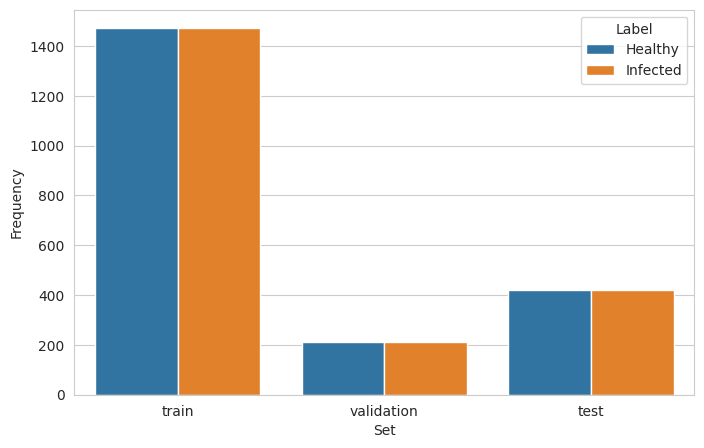

In [9]:
import pandas as pd

# Create an empty dictionary to store data
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# List of dataset folders
folders = ['train', 'validation', 'test']

# Go through each folder and label to count the images
for folder in folders:
    for label in labels:
        row = {
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))  
        }
        for key, value in row.items():
            data[key].append(value)
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

# Convert the dictionary into a DataFrame
df_freq = pd.DataFrame(data)

print("\n")

# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

# Create a bar chart to show image distribution
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

Image Data Generator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-01-30 11:10:13.172757: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 11:10:13.201558: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


- Initialize image data generator

In [11]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

- Augment training image dataset

In [12]:
batch_size = 20
train_set = augmented_image_data.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment validation image dataset

In [13]:
validation_set = ImageDataGenerator(
    rescale=1./255).flow_from_directory(val_path,
                                        target_size=image_shape[:2],
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=False
                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment test image dataset

In [14]:
test_set = ImageDataGenerator(
    rescale=1./255).flow_from_directory(test_path,
                                        target_size=image_shape[:2],
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=False
                                        )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

### Plot augmented training images

(20, 128, 128, 3)


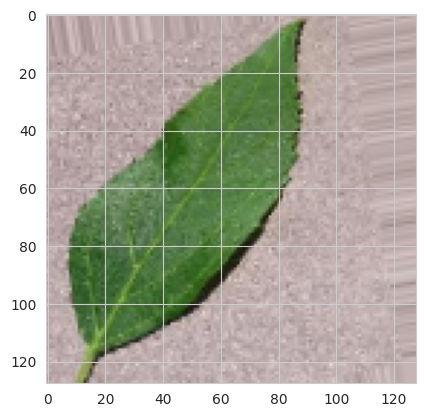

(20, 128, 128, 3)


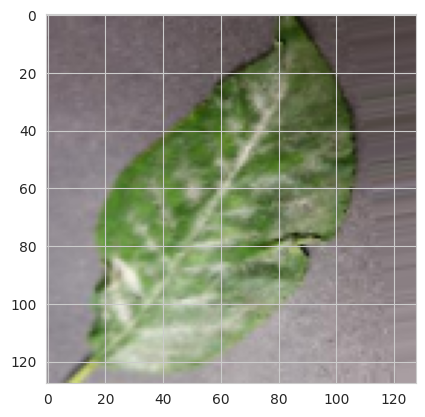

(20, 128, 128, 3)


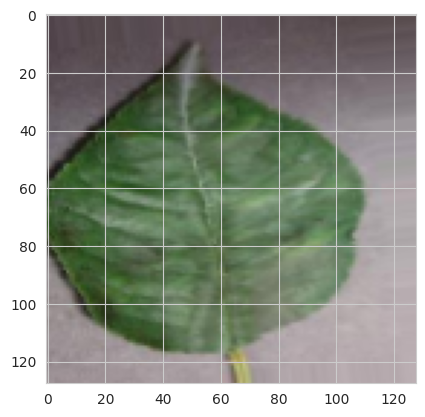

In [15]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot augmented validation images

(20, 128, 128, 3)


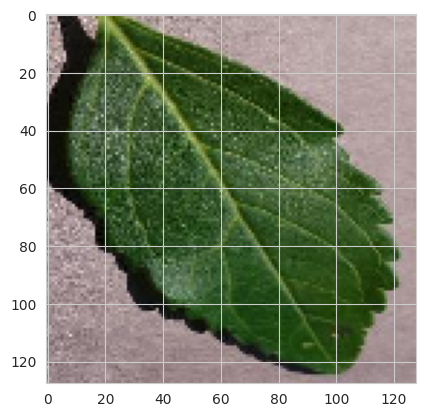

(20, 128, 128, 3)


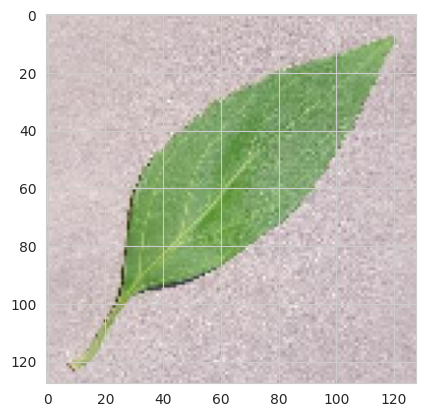

(20, 128, 128, 3)


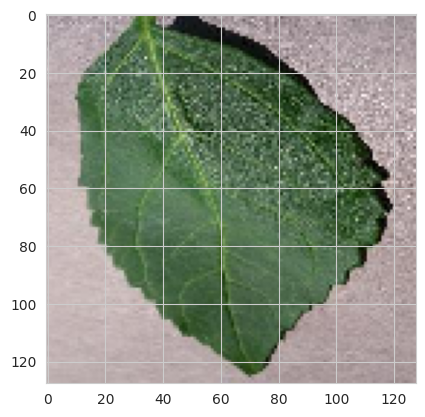

In [16]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot augmented test images

(20, 128, 128, 3)


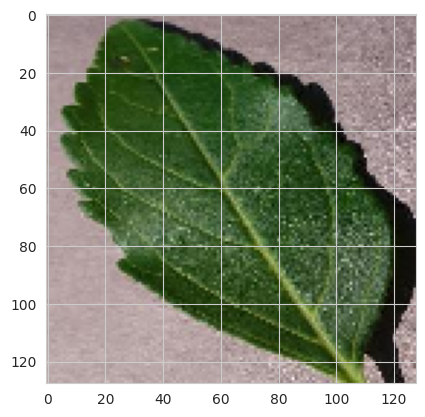

(20, 128, 128, 3)


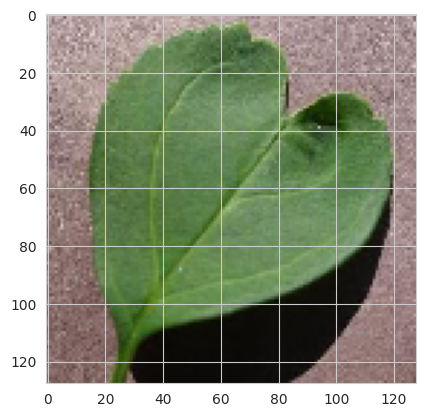

(20, 128, 128, 3)


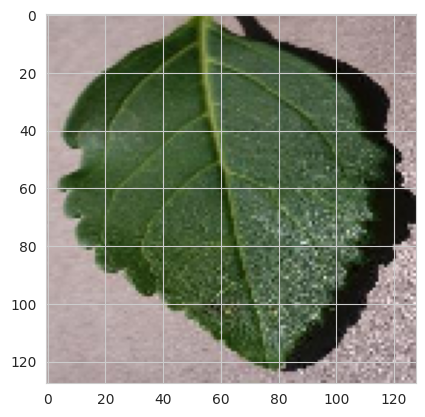

In [17]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model Creation

- Import model packages

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

- Model

In [20]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

- Model Summary

In [21]:
create_tf_model().summary()

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 830,913 (3.17 MB)

 Trainable params: 830,913 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

- Early Stopping 

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

### Fit model for model training

In [23]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25


/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 668ms/step - accuracy: 0.4899 - loss: 0.6891 - val_accuracy: 0.5000 - val_loss: 0.7152
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 602ms/step - accuracy: 0.5896 - loss: 0.6658 - val_accuracy: 0.5000 - val_loss: 0.6525
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 601ms/step - accuracy: 0.5381 - loss: 0.6632 - val_accuracy: 0.6238 - val_loss: 0.6660
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 617ms/step - accuracy: 0.6751 - loss: 0.6688 - val_accuracy: 0.8690 - val_loss: 0.5892
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 635ms/step - accuracy: 0.7503 - loss: 0.5657 - val_accuracy: 0.8571 - val_loss: 0.3886
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 549ms/step - accuracy: 0.8769 - loss: 0.3614 - val_accuracy: 0.8810 - val_loss: 0.2561
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 616ms/step - accuracy: 0.8416 - loss: 0.3808 - val_accuracy: 0.8929 - val_loss: 0.2797
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 616ms/step - accuracy: 0.8546 - loss: 0.2992 - val_accuracy: 0.9119 - val_loss: 0.1897
Epo

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 1.0000 - loss: 0.0374 - val_accuracy: 0.9905 - val_loss: 0.0473
Epoch 23/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 600ms/step - accuracy: 0.9874 - loss: 0.0447 - val_accuracy: 0.9905 - val_loss: 0.0343
Epoch 24/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 601ms/step - accuracy: 0.9730 - loss: 0.0660 - val_accuracy: 0.9905 - val_loss: 0.0359
Epoch 25/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 617ms/step - accuracy: 0.9864 - loss: 0.0489 - val_accuracy: 0.9881 - val_loss: 0.0456


### Save model

In [24]:
model.save('outputs/v1/mildew_detector_model.h5')

---

## Model Performance

### Model learning curve

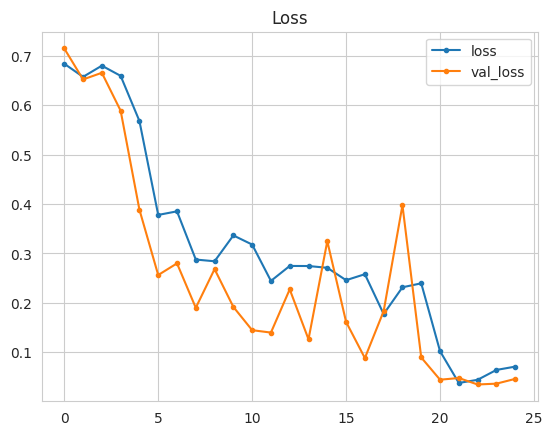

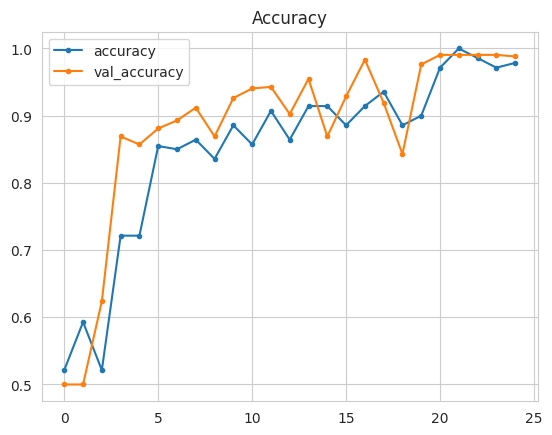

In [25]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Load saved model

In [26]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.h5')

Evaluate model on test set

In [27]:
evaluation = model.evaluate(test_set)

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9952 - loss: 0.0126


### Save evaluation pickle

In [28]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

### Confusion Matrix & Evaluation Report

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step
Classification Report:

              precision    recall  f1-score   support

     Healthy       0.98      1.00      0.99       422
    Infected       1.00      0.98      0.99       422

    accuracy                           0.99       844
   macro avg       0.99      0.99      0.99       844
weighted avg       0.99      0.99      0.99       844



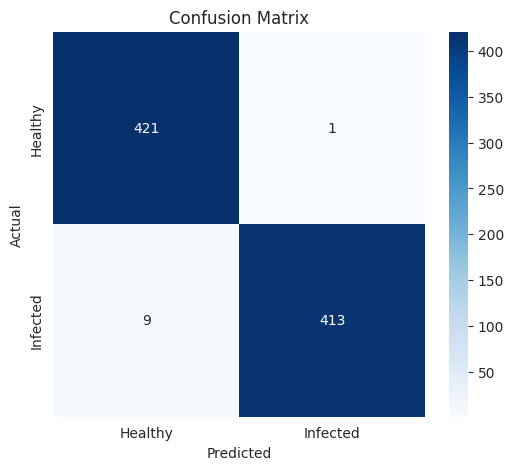

In [30]:
# Obtain predictions
y_pred = model.predict(test_set)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary values (1 if > 0.5, otherwise 0)

# Obtain true labels
y_true = test_set.classes

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Infected']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'Infected'], yticklabels=['Healthy', 'Infected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f'{file_path}/confusion_matrix.png', bbox_inches='tight', dpi=150)
plt.show()

### Predict on new data

Load a random image as PIL

Image shape: (128, 128), Image mode: RGB


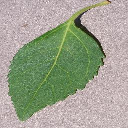

In [31]:
from tensorflow.keras.preprocessing import image

pointer = 50
label = labels[0]  

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [32]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 128, 128, 3)


Predict class probabilities

In [33]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
0.9999695757123845
Healthy


---